In [1]:
import sys,obspy,os,glob,time
import numpy as np
import pandas as pd
from seisgo.utils import split_datetimestr
from seisgo import downloaders,noise,utils,monitoring
from obspy import clients

C:\Users\Yoram\AppData\Local\Temp\ipykernel_4176\3931977152.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# paths and filenames
rootpath = "data_SK_test" # roothpath for the project
DATADIR  = os.path.join(rootpath,'Raw')                   # where to store the downloaded data
down_list  = os.path.join(DATADIR,'station.txt')
# CSV file for station location info

# download parameters
source='IRIS'                                 # client/data center. see https://docs.obspy.org/packages/obspy.clients.fdsn.html for a list
max_tries = 3                                                  #maximum number of tries when downloading, in case the server returns errors.
flag      = True                                               # print progress when running the script; recommend to use it at the begining
samp_freq = 5                                                  # targeted sampling rate at X samples per seconds
rmresp   = True
rmresp_out = 'DISP'
pressure_chan = [None]  #Added by Xiaotao Yang. This is needed when downloading some special channels, e.g., pressure data. VEL output for these channels.
freqmin   = 0.05                                                # pre filtering frequency bandwidth
freqmax   = 0.5*samp_freq
# note this cannot exceed Nquist freq

# targeted region/station information: only needed when use_down_list is False
lamin,lamax,lomin,lomax= 59.9605,60.1538,-139.9209,-139.4938                # regional box: min lat, min lon, max lat, max lon (-114.0)
chan_list = ["HH2"]
net_list  = ["YG"] #                                             # network list
sta_list  = ["SE9","SW8"]                                       # station (using a station list is way either compared to specifying stations one by one)
start_date = "2021_05_01_0_0_0"                                 # start date of download
end_date   = "2021_09_01_0_0_0"                                 # end date of download
inc_hours  = 96                                                 # length of data for each request (in hour)
maxseischan = 1                                                  # the maximum number of seismic channels, excluding pressure channels for OBS stations.
ncomp      = maxseischan #len(chan_list)

##################################################
# we expect no parameters need to be changed below
# assemble parameters used for pre-processing waveforms in downloading
prepro_para = {'rmresp':rmresp,'rmresp_out':rmresp_out,'freqmin':freqmin,'freqmax':freqmax,\
                'samp_freq':samp_freq}

downlist_kwargs = {"source":source, 'net_list':net_list, "sta_list":sta_list, "chan_list":chan_list, \
                    "starttime":start_date, "endtime":end_date, "maxseischan":maxseischan, "lamin":lamin, "lamax":lamax, \
                    "lomin":lomin, "lomax":lomax, "pressure_chan":pressure_chan, "fname":down_list}




In [3]:
# define user credentials fro accessing embargoed data 
user = 'username'
password = 'password'
credentials = [user,password]

In [4]:
tt0=time.time()

if not os.path.isdir(DATADIR):os.makedirs(DATADIR)
stalist=downloaders.get_sta_list(**downlist_kwargs) # saves station list to "down_list" file
                                          # here, file name is "station.txt"
# save parameters for future reference
metadata = os.path.join(DATADIR,'download_info.txt')
fout = open(metadata,'w')
fout.write(str({**prepro_para,**downlist_kwargs,'inc_hours':inc_hours,'ncomp':ncomp}));fout.close()

all_chunk = split_datetimestr(start_date,end_date,inc_hours)
if len(all_chunk)<1:
    raise ValueError('Abort! no data chunk between %s and %s' % (start_date,end_date))

########################################################
#################DOWNLOAD SECTION#######################
########################################################
# loop through each time chunk
for ick in range(len(all_chunk)-1):
    s1= all_chunk[ick]
    s2=all_chunk[ick+1]
    
    print('time segment:'+s1+' to '+s2)
    
    download_kwargs = {"source":source,"rawdatadir": DATADIR, "starttime": s1, "endtime": s2, \
              "stationinfo": down_list,"credentials":credentials,"verbose":True, **prepro_para}

    # Download for ick
    downloaders.download(**download_kwargs)

tt1=time.time()
print('downloading step takes %6.2f s' %(tt1-tt0))

time segment:2021_05_01_00_00_00 to 2021_05_05_00_00_00
YG.SE9.HH2  downloading ... try 1
Entered credentials: yterleth@uidaho.edu JA5DdFwCNaRfCS3p
number of segments downloaded: 1
station YG.SE9 --> seismic channel: HH2
  downsamping from 250 to 5
  removing response using inv for YG.SE9.HH2
  downloaded YG.SE9.HH2 in 59.893301486968994 seconds.
 Saving data for YG.SE9.HH2
YG.SW8.HH2  downloading ... try 1
Entered credentials: yterleth@uidaho.edu JA5DdFwCNaRfCS3p
number of segments downloaded: 1
station YG.SW8 --> seismic channel: HH2
  downsamping from 250 to 5
  removing response using inv for YG.SW8.HH2
  downloaded YG.SW8.HH2 in 47.59546971321106 seconds.
 Saving data for YG.SW8.HH2
time segment:2021_05_05_00_00_00 to 2021_05_09_00_00_00
YG.SE9.HH2  downloading ... try 1
Entered credentials: yterleth@uidaho.edu JA5DdFwCNaRfCS3p
number of segments downloaded: 1
station YG.SE9 --> seismic channel: HH2
  downsamping from 250 to 5
  removing response using inv for YG.SE9.HH2
  downloa

In [ ]:
# absolute path parameters
CCFDIR    =        'D:/NOISE/CC/'                            # dir to store CC data

# some control parameters
freq_norm   = 'rma'                                                         # 'no' for no whitening, or 'rma' for running-mean average, 'phase' for sign-bit normalization in freq domain
time_norm   = 'no'                                                          # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'                                                       # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma" and time_norm to "no"
acorr_only  = False                                                         # only perform auto-correlation
xcorr_only  = True                                                         # only perform cross-correlation or not

# pre-processing parameters
cc_len    = 3600*2                                                            # basic unit of data length for fft (sec)
step      = 3600*1                                                             # overlapping between each cc_len (sec)

# cross-correlation parameters
maxlag         = 50                                                        # lags of cross-correlation to save (sec)
substack       = True                                                      # sub-stack daily cross-correlation or not
substack_len   = cc_len                                                  # how long to stack over (for monitoring purpose): need to be multiples of cc_len

freqmin   = 0.05
freqmax   = 2.5
##################################################
# make a dictionary to store all variables: also for later cc
fc_para={'cc_len':cc_len,'step':step,'freqmin':freqmin,'freqmax':freqmax,
        'freq_norm':freq_norm,'time_norm':time_norm,'cc_method':cc_method,
        'substack':substack,'substack_len':substack_len,'maxlag':maxlag}
# save fft metadata for future reference
fc_metadata  = os.path.join(CCFDIR,'fft_cc_data.txt')
#if not os.path.isdir(CCFDIR):os.makedirs(CCFDIR)
# save metadata
fout = open(fc_metadata,'w')
fout.write(str(fc_para));fout.close()

# set variables to broadcast
tdir = sorted(glob.glob(os.path.join(DATADIR,'*.h5')))

#loop through all data files.
for i in range(len(tdir)):
    sfile=tdir[i]
    #call the correlation wrapper.
    noise.do_correlation(sfile,cc_len,step,maxlag,cc_method=cc_method,
                         acorr_only=acorr_only,xcorr_only=xcorr_only,substack=substack,
                         substack_len=substack_len,freqmin=freqmin,freqmax=freqmax,
                         time_norm=time_norm,freq_norm=freq_norm,outdir=CCFDIR)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/NOISE/CC/fft_cc_data.txt'

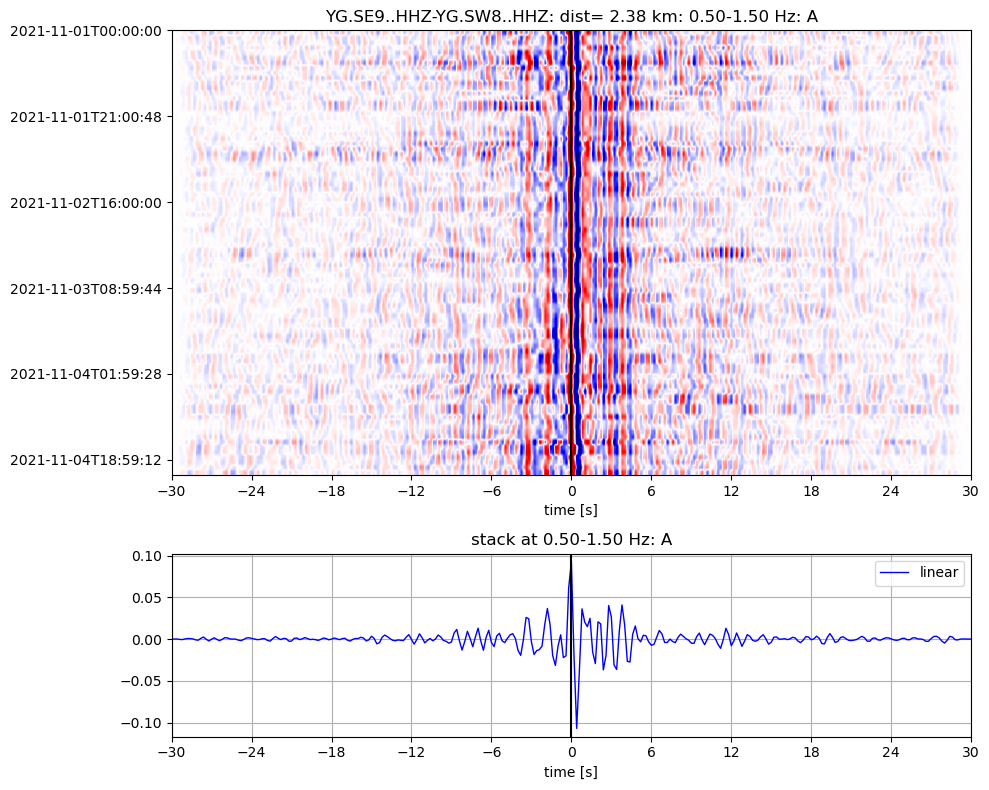

In [ ]:
new_dir = 'D:/NOISE/CC/'
ccfiles = sorted(glob.glob(os.path.join(new_dir,'*.h5')))

corrdata=noise.extract_corrdata(ccfiles[0])
clist=list(corrdata.keys())
cc_comp='ZZ'
corrdata[clist[0]][cc_comp].plot(freqmin=.5,freqmax=1.5,lag=30)

In [ ]:
'''
Stacking script of SeisGo to:
    1) load cross-correlation data for each station pair
    2) merge all time chuncks
    3) save outputs in ASDF;
'''
MERGEDIR  = os.path.join(rootpath,'MERGED_PAIRS')                          # dir where stacked data is going to
###########PROCESSING SECTION##########
if not os.path.isdir(MERGEDIR):os.mkdir(MERGEDIR)
# cross-correlation files
ccfiles   = sorted(glob.glob(os.path.join(new_dir,'*.h5')))
pairs_all,netsta_all=noise.get_stationpairs(ccfiles,False)

for s in netsta_all:
    tmp = os.path.join(MERGEDIR,s)
    if not os.path.isdir(tmp):os.mkdir(tmp)

# MPI loop: loop through each user-defined time chunck
for ipair in range(len(pairs_all)):
    pair=pairs_all[ipair]
    if flag:print('station-pair %s'%(pair))
    noise.merge_pairs(ccfiles,pairlist=pair,outdir=MERGEDIR,verbose=True)
          

station-pair YG.SE9_YG.SW8
assembling all corrdata for pair [YG.SE9_YG.SW8] ...
finished assembling in   0.07s ...
save to data_SK_test\MERGED_PAIRS\YG.SE9\YG.SE9_YG.SW8.h5 and data_SK_test\MERGED_PAIRS\YG.SE9\YG.SE9_YG.SW8.h5
CorrData saved to: data_SK_test\MERGED_PAIRS\YG.SE9\YG.SE9_YG.SW8.h5


In [ ]:
#####FILE LOCATIONS#####
direc  = os.path.join(rootpath,'MERGED_PAIRS')
print(direc)

######PARAMTERS######
source='YG.SE9'                            #source station
receiver = 'YG.SW8'                        #reciever station
cc_comp = 'ZZ'                              #Which components to use (ZZ, EZ, EN, EE, NZ, NN)
#file handling#
key=source+'_'+receiver
ccfile=sorted(glob.glob(os.path.join(direc,source,'*'+receiver+'*.h5')))[0]

###### Loading Waveform Data #######
corrdata=noise.extract_corrdata(ccfile,pair=source+'_'+receiver,comp=cc_comp)
cdataall=corrdata[key][cc_comp].copy()
cdata=corrdata[key][cc_comp].copy()

data_SK_test\MERGED_PAIRS


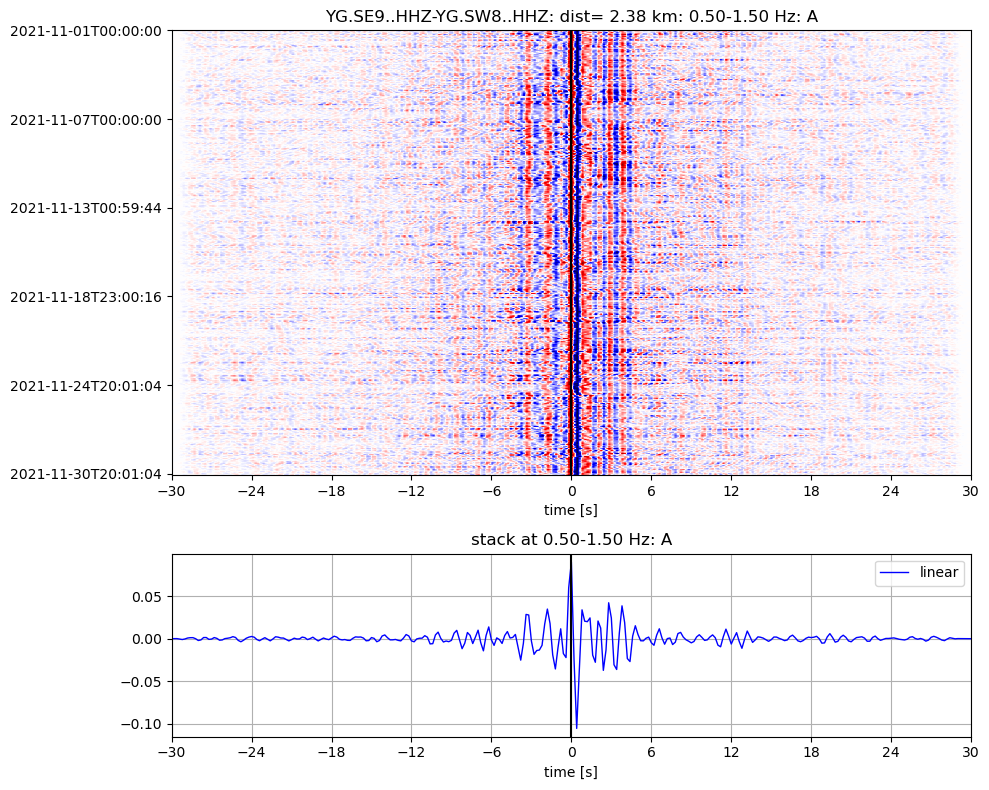

In [ ]:
freq = [0.5,1.5]                              #targeted frequency band for monitoring
cdata.plot(freqmin=freq[0],freqmax=freq[1],lag=30)

working on 60 windows with 10 workers.


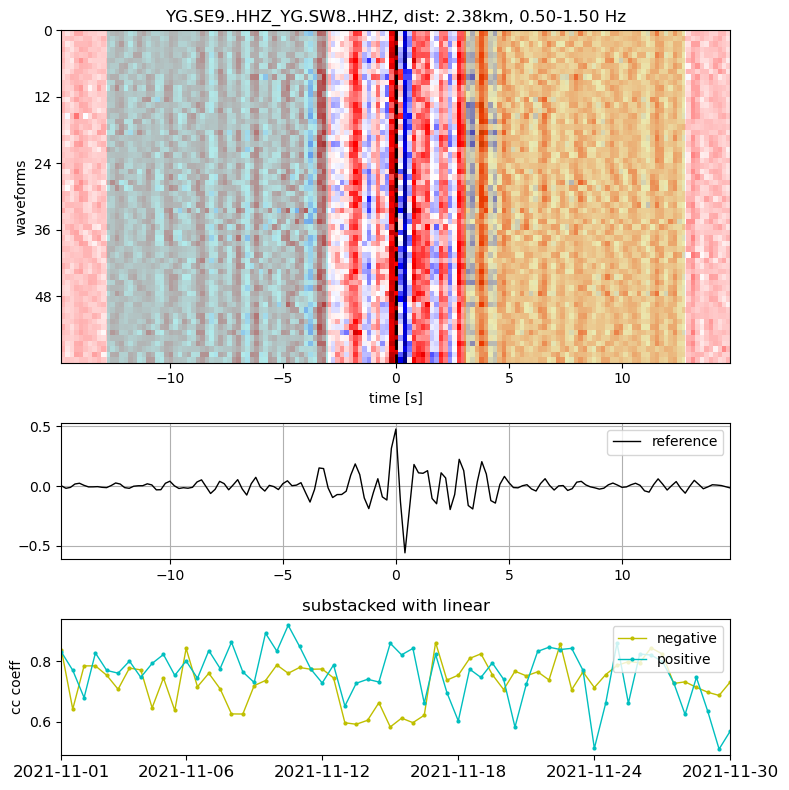

with 10 processors, took 20.667827 seconds


In [ ]:
save = True                                 #Save?
freq = [0.5,1]                              #targeted frequency band for monitoring
win_len = 3600*12                           #Window length i.e. Resolution
offset=2
vmin = 2.5                                    #minimum velocity of the direct waves -> 
#start of the coda waveforms
lwin = 5/freq[0]                                    #window length in seconds for the coda waves

dv_max = 3/100                              #limit for the dv/v

t1=time.time()
nproc=10 #number of processors to use.
vdata=monitoring.get_dvv(cdataall,freq,lwin,resolution=win_len,vmin=vmin,dvmax=dv_max,offset=offset,\
                         method='ts',plot=True,nproc=nproc)
print("with %d processors, took %f seconds"%(nproc,time.time()-t1))

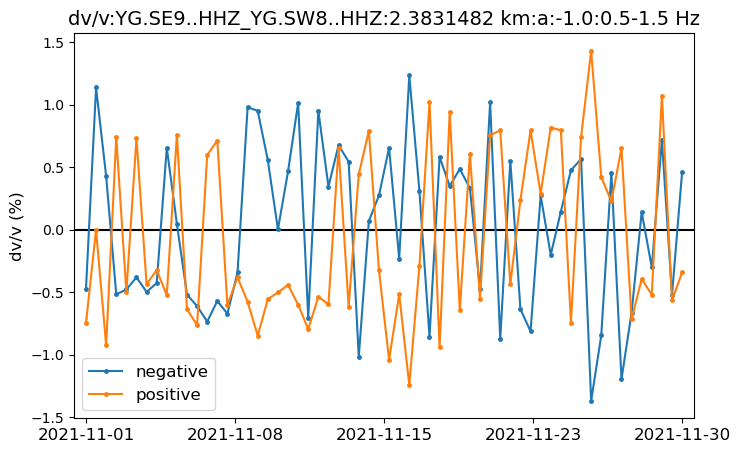

In [ ]:
vdata.plot(errorbar=False)